# TGDS Hybrid Model

In [1]:
import context
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import src.data.data_preprocessing as util
import src.models.lstm_model as lstm

tf.compat.v1.set_random_seed(1)

### Set Hyperparameters

In [2]:
HYPER_PARAMS =  np.load('../../../models/TGDS/training_setup/hyperparameters.npy', allow_pickle=True)
HYPER_PARAMS = HYPER_PARAMS.item()

# add aditional model-spefic hyperparameters
model_hyperparameters = {
    'n_features': 2,       # number of input features
    'd_t': 0.25,           # current integration factor
    'num_repeat': 1,      # repetition factor for each training profile to create more auxiliary data
    'theory_model': 2228,  # the unique thevenin model ID for which the parameters have been computed
}

# update hyperparameters
HYPER_PARAMS.update(model_hyperparameters)

### Prepare Training/Validation/Test Data

In [3]:
TRAINING_SETS =  np.load('../../../models/TGDS/training_setup/training_sets.npy', allow_pickle=True)
TRAINING_SETS = TRAINING_SETS.item()

# select correct training set
# training_sets = TRAINING_SETS['10A_all'] + TRAINING_SETS['-10A_all'] + TRAINING_SETS['25A_all'] + TRAINING_SETS['-25A_all']
training_sets = TRAINING_SETS['10A_all'] 

train_data = []
for set in training_sets:
    set_repeat = [set] * HYPER_PARAMS['num_repeat']
    train_data += set_repeat
    
train_data = np.array(train_data)

# select first profile for validation
validation_profile = [train_data[0]]

# select arbitrary profile for testing
test_profile = np.random.choice(train_data, 1) 

# prepare input data
X_train, y_train, scalers_train = util.prepare_hybrid_input(HYPER_PARAMS, train_data, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_validation, y_validation, _ = util.prepare_hybrid_input(HYPER_PARAMS, validation_profile, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_test, y_test, _ = util.prepare_hybrid_input(HYPER_PARAMS, test_profile, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])

Input: (9350, 100, 2)  Output/Label: (9350, 1)
Input: (1500, 100, 2)  Output/Label: (1500, 1)
Input: (1650, 100, 2)  Output/Label: (1650, 1)


### Initialize and Train Model

In [4]:
lstm = lstm.Model()
lstm.initialize(HYPER_PARAMS)

Model: "Black_Box_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10600     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                5680      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 16,301
Trainable params: 16,301
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
293/293 [==============================] - 43s 146ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0216
Epoch 2/5
293/293 [==============================] - 42s 142ms/step - loss: 2.4722e-04 - mse: 2.4722e-04 - mae: 0.0120
Epoch 3/5
293/293 [==============================] - 41s 141ms/step - loss: 2.3866e-04 - mse: 2.3866e-04 - mae: 0.0118
Epoch 4/5
293/293 [==============================] - 41s 140ms/step - loss: 2.3324e-04 - mse: 2.3324e-04 - mae: 0.0117
Epoch 5/5
293/293 [==============================] - 41s 139ms/step - loss: 2.3376e-04 - mse: 2.3376e-04 - mae: 0.0117
Training time: 208.128s


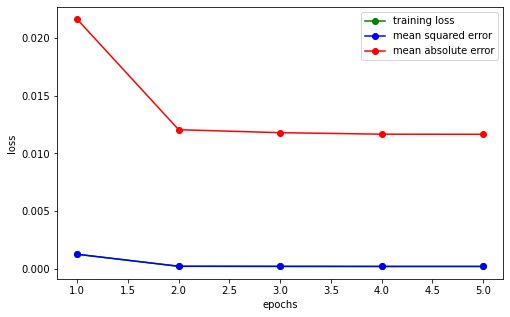

INFO:tensorflow:Assets written to: ../../../models/TGDS/1557\assets


In [5]:
_, fig = lstm.train(X_train, y_train, scalers_train)

# save model, hyperparameters and plots
MODEL_ID = str(np.random.randint(10000))

lstm.model.save('../../../models/TGDS/' + str(MODEL_ID))
np.save('../../../models/TGDS/' + str(MODEL_ID) + '/hyperparameters', HYPER_PARAMS)
fig.savefig('../../../reports/figures/theory_guided_hybrid-' + str(MODEL_ID) + '-learning_curve.png')

### Test Model

Validation Profile: ['Profile 10A']
Test Profile: ['Profile 10A Run 040618']
293/293 [==============================] - 17s 57ms/step
Prediction time on Training Set:  16.65s
47/47 [==============================] - 3s 56ms/step
Prediction time on Validation Set:  2.689s
52/52 [==============================] - 3s 56ms/step
Prediction time on Test Set:  2.983s
###########################################################
            Training    Validation    Test
--------  ----------  ------------  ------
MSE (μV)      30.6          8.3     4.7
MAE (V)        0.004        0.0024  0.0017
MaxE (V)       0.016        0.0094  0.0056
###########################################################


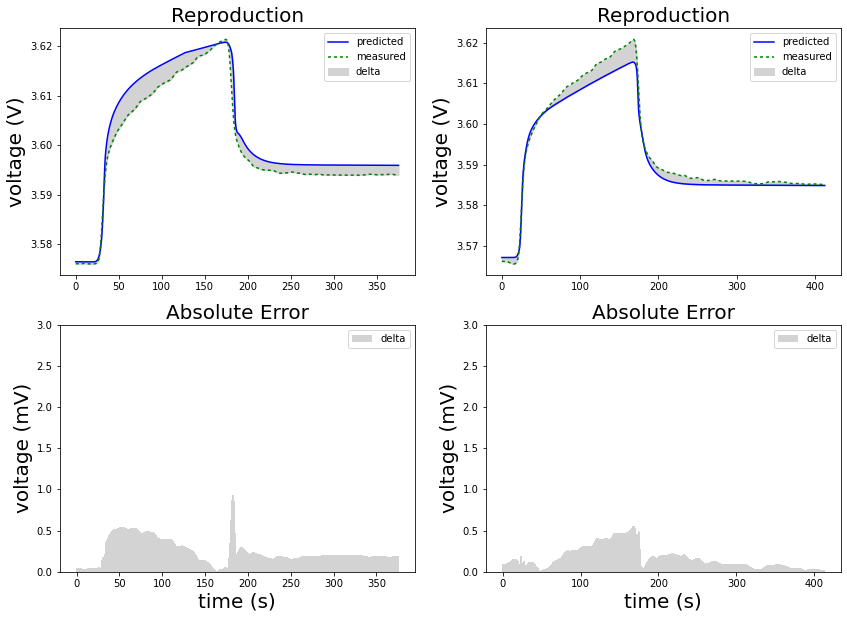

In [6]:
print('Validation Profile:', validation_profile)
print('Test Profile:', test_profile)

yhat_train_unscaled, _, _, _, _, fig = lstm.test(X_train, y_train, X_validation, y_validation, X_test, y_test, scalers_train)

# save plots and predicted sequences
np.save('../../../models/TGDS/' + str(MODEL_ID) + '/predictions', yhat_train_unscaled)
fig.savefig('../../../reports/figures/theory_guided_hybrid-' + str(MODEL_ID) + '-validation&test_profiles.png')

### Prepare Data for Use Cases

In [7]:
TEST_SETS =  np.load('../../../models/TGDS/training_setup/test_sets.npy', allow_pickle=True)
TEST_SETS = TEST_SETS.item()

test_profiles_usecase_1 = TEST_SETS['Reproduction']
test_profiles_usecase_2 = TEST_SETS['Abstraction']
test_profiles_usecase_3 = TEST_SETS['Generalization']

X_case_1, y_case_1, _ = util.prepare_hybrid_input(HYPER_PARAMS, test_profiles_usecase_1, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_case_2, y_case_2, _ = util.prepare_hybrid_input(HYPER_PARAMS, test_profiles_usecase_2, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_case_3, y_case_3, _ = util.prepare_hybrid_input(HYPER_PARAMS, test_profiles_usecase_3, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])

Input: (1500, 100, 2)  Output/Label: (1500, 1)
Input: (3100, 100, 2)  Output/Label: (3100, 1)
Input: (1600, 100, 2)  Output/Label: (1600, 1)


### Test Model on Use Cases

Use Case 1: ['Profile 10A']
Use Case 2: ['Profile 10A 3x']
Use Case 3: ['Profile -10A']
293/293 [==============================] - 17s 57ms/step
Prediction time on Training Set:  16.715s
47/47 [==============================] - 3s 56ms/step
Prediction time on Use Case 1:  2.681s
97/97 [==============================] - 5s 56ms/step
Prediction time on Use Case 2:  5.526s
50/50 [==============================] - 3s 56ms/step
Prediction time on Use Case 3:  2.85s
##############################################################
            Training    Use Case 1    Use Case 2    Use Case 3
--------  ----------  ------------  ------------  ------------
MSE (μV)      30.6          8.3          25.9          30.8
MAE (V)        0.004        0.0024        0.004         0.0038
MaxE (V)       0.016        0.0094        0.0119        0.0099
##############################################################


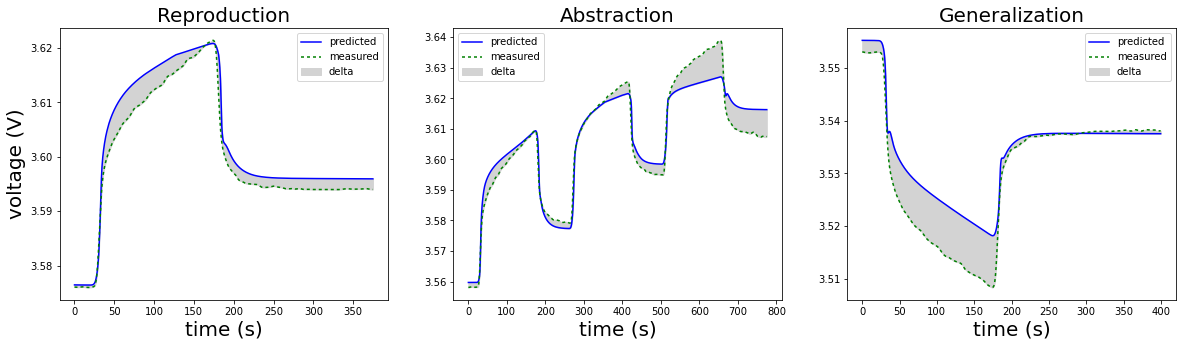

In [8]:
print('Use Case 1:', test_profiles_usecase_1)
print('Use Case 2:', test_profiles_usecase_2)
print('Use Case 3:', test_profiles_usecase_3)

lstm.test_usecases(X_train, y_train, X_case_1, y_case_1, X_case_2, y_case_2, X_case_3, y_case_3, scalers_train)